In [1]:
import sys
import os.path as p

sys.path.append("/home/j-gunmo/desktop/00.my-project/17.P-Stage-T1003/4-STAGE/")

from fe.feature import FEBase, FEPipeline

from fe.agg import (
    MakeCorrectCount, 
    MakeCorrectPercent, 
    MakeQuestionCount, 
    MakeTopNCorrectPercent
)

from fe.seq import (
    SplitAssessmentItemID,
    MakeFirstClass,
    MakeSecondClass,
    MakeTimeDiff,
    MakeYMD,
    ConvertTime
)

import easydict
from IPython.display import clear_output

from dkt_dataset import Preprocess
from utils import get_args, get_root_dir

In [2]:
args = get_args()
args.data_dir = "../../input/data/train_dataset/"
args.root_dir = get_root_dir("../loss_test/")

In [3]:
args.num_workers = 2
args.n_epochs = 10
args.hidden_dim = 1024
args.use_dynamic = True

In [4]:
import torch
from trainer import DKTTrainer
from models.lstm.model import LSTM
from utils import get_criterion

class Loss1Trainer(DKTTrainer):  # 원래 코드
    def _collate_fn(self, batches):
        """ key값으로 batch 형성 """
        new_batches = {k: [] for k in batches[0].keys()}

        # batch의 값들을 각 column끼리 그룹화
        for k in batches[0].keys():
            for batch in batches:
                pre_padded = torch.zeros(self.args.max_seq_len)
                pre_padded[-len(batch[k]) :] = batch[k]
                new_batches[k].append(pre_padded)

        for k in batches[0].keys():
            new_batches[k] = torch.stack(new_batches[k])

        return new_batches

    def _process_batch(self, batch):
        batch['mask'] = batch['mask'].type(torch.FloatTensor)
        batch["answerCode"] = batch["answerCode"].type(torch.FloatTensor)

        batch["interaction"] = batch["answerCode"] + 1
        batch["interaction"] = batch["interaction"].roll(shifts=1, dims=1)
        batch["mask"] = batch["mask"].roll(shifts=1, dims=1)
        batch["mask"][:, 0] = 0
        batch["interaction"] = (batch["interaction"] * batch["mask"]).to(torch.int64)
        
        
        for k in args.n_linears: # 수치형
            batch[k] = batch[k].type(torch.FloatTensor)
            
        for k, v in args.n_embeddings.items(): # 범주형
            batch[k] = batch[k].to(torch.int64)
            
        for k in batch.keys():
            batch[k] = batch[k].to(self.args.device)
        
        return batch
    
class Loss2Trainer(Loss1Trainer):
    def _compute_loss(self, preds, targets):
        loss = get_criterion(preds, targets)
        loss = loss[:, -2:]
        loss = torch.mean(loss)
        return loss
    
class Loss5Trainer(Loss1Trainer):
    def _compute_loss(self, preds, targets):
        loss = get_criterion(preds, targets)
        loss = loss[:, -5:]
        loss = torch.mean(loss)  # scalar 형태가 아니면 loss.backward가 안된다.
        return loss
    
class Loss10Trainer(Loss1Trainer):
    def _compute_loss(self, preds, targets):
        loss = get_criterion(preds, targets)
        loss = loss[:, -10:]
        loss = torch.mean(loss)
        return loss
    
class LossAllTrainer(Loss1Trainer):
    def _compute_loss(self, preds, targets):
        loss = get_criterion(preds, targets)
        loss = torch.mean(loss)
        return loss

In [5]:
import pandas as pd
from fe.agg import AggFeBase

class MakeDifficultyByFirstClass(AggFeBase):
    name = "make_difficulty_by_firstclass"
    description = {
        "firstClassDifficulty" : "유저의 대분류별 정답률을 나타냅니다."
    }
    
    pre_fe = {"make_first_class"}
    agg_column = ["userID", "firstClass"]
    
    @classmethod
    def _transform(cls, df):
        grouped_df = df.groupby(cls.agg_column).answerCode.mean()
        a, b = zip(*grouped_df.index)
        
        right_df = pd.DataFrame(
            {"userID": a, "firstClass": b, "firstClassDifficulty": list(grouped_df)}
        )
        
        return right_df

In [6]:
args.num_workers = 4
args.n_epochs = 10
args.hidden_dim = 1024
args.use_dynamic = True

In [7]:
fe_pipeline = FEPipeline(
    args, [
        SplitAssessmentItemID,
        ConvertTime,
        MakeFirstClass,
        MakeSecondClass,
        MakeCorrectCount,
        MakeQuestionCount,
        MakeCorrectPercent,
        MakeDifficultyByFirstClass
    ]
)

columns = [
    "userID",
    "answerCode",
    "testPaper",
    "timeSec",
    "firstClass",
    "secondClass",
    "correctPer",
    "firstClassDifficulty"
]

pre_encoders = {
    "label": ["testPaper", "firstClass", "secondClass"],
    "min_max": ["correctPer"],
    "std": ["timeSec", "firstClassDifficulty"],
}

## PrePare

In [8]:
preprocess = Preprocess(args, fe_pipeline, columns)

# preprocess.feature_engineering()
# preprocess.split_data()
# preprocess.scaling(pre_encoders)
# preprocess.data_augmentation(choices=[1, 3])
preprocess.preprocessing(pre_encoders)

clear_output()

In [9]:
train_dataset = preprocess.get_data("train_grouped")
valid_dataset = preprocess.get_data("valid_grouped")
test_dataset = preprocess.get_data("test_grouped")

In [10]:
args.columns = columns[1:]

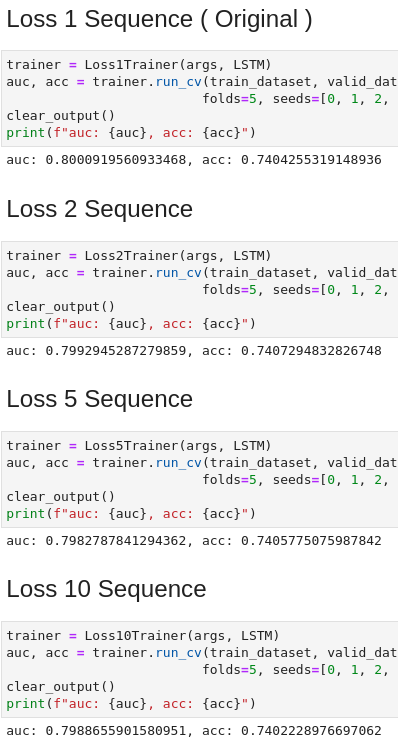

### 이전 전처리 방법으로 LB Score 체크

In [8]:
preprocess = Preprocess(args, fe_pipeline, columns)

preprocess.feature_engineering()
preprocess.split_data()
preprocess.scaling(pre_encoders)
preprocess.data_augmentation(choices=[1, 3])
# preprocess.preprocessing(pre_encoders)

clear_output()

In [9]:
train_dataset = preprocess.get_data("train_grouped")
valid_dataset = preprocess.get_data("valid_grouped")
test_dataset = preprocess.get_data("test_grouped")

In [10]:
args.columns = columns[1:]
args.columns

['answerCode',
 'testPaper',
 'timeSec',
 'firstClass',
 'secondClass',
 'correctPer',
 'firstClassDifficulty']

In [11]:
trainer = Loss1Trainer(args, LSTM)
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()
print(f"auc: {auc}, acc: {acc}")

auc: 0.785958090266418, acc: 0.6943768996960487


LB AUC : 0.7223  LB ACC : 0.6640

In [12]:
trainer.prefix_save_path

'../loss_test/LOG_[06.10_11:54]'

### 전처리 이전, use_dynamic False 한 이후로 LB Score 체크

In [14]:
args.use_dynamic = False

In [15]:
trainer = Loss1Trainer(args, LSTM)
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()
print(f"auc: {auc}, acc: {acc}")
print(f"logging path : {trainer.prefix_save_path}")

auc: 0.7942036907026714, acc: 0.7220871327254306
logging path : ../loss_test/LOG_[06.10_12:38]


LB AUC: 0.7436 LB ACC : 0.6882

In [34]:
preprocess.get_data("test")

,userID,answerCode,testPaper,timeSec,firstClass,secondClass,correctPer,firstClassDifficulty
0,3,1,804,-2.351056,4,267,0.69112,-0.011007
1,3,1,804,-2.351053,4,267,0.69112,-0.011007
2,3,0,804,-2.351039,4,266,0.69112,-0.011007
3,3,0,804,-2.351038,4,266,0.69112,-0.011007
4,3,0,804,-2.351037,4,265,0.69112,-0.011007
...,...,...,...,...,...,...,...,...
260109,7439,0,713,1.091057,3,783,0.62500,-0.140976
260110,7439,1,713,1.091060,3,783,0.62500,-0.140976
260111,7439,1,713,1.091063,3,761,0.62500,-0.140976
260112,7439,1,713,1.091076,3,761,0.62500,-0.140976


- 점수 차이가 나는 이유가... Feature Engineering을 한 이후로 Split을 해줘서 ValidData에 정답 유출이 있는 것 같음...

In [17]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

class LableProcess(Preprocess):
    def feature_engineering(self):
        """ Feature engineering을 진행합니다. """
        for key in ["train", "test"]:
            assert self.datas[key] is not None, f"you must loads {key} dataset"
            df = self.fe_pipeline.transform(self.datas[key], key)
            self.datas[key] = df[self.columns]
            
    def scaling(self, pre_encoders):
        """기계가 처리 가능하도로 변환, "train", "test"에 대해서만 수행
        label   : LabelEncoder
        min_max : MinMaxScaler
        std     : StandardScaler
        """
        assert (
            len(set(pre_encoders.keys()).intersection(set(["label", "min_max", "std"]))) == 3
        ), "pre_encoders의 key값을 ('label', 'min_max', 'std') 다 입력해주세요."

        encoders = {}
        self.args.n_embeddings = easydict.EasyDict()
        self.args.n_linears = list()

        self.logger.info("Preprocessing Labels .. ")
        self.logger.info(f"Label Columns: {pre_encoders['label']}")

        for k in pre_encoders["label"]:
            encoders[k] = LabelEncoder()
            labels = self.datas["train"][k].unique().tolist() + ["unknown"]
            self.args.n_embeddings[k] = len(labels)

            # TODO: Label HistoGram 그리기..?
            self.logger.info(f"\nLength of {k:<20} : {len(labels)}")

            # Train Fit Transform
            encoders[k].fit(labels)
            self.datas["train"][k] = self.datas["train"][k].astype(str)
            self.logger.info(f"Before : {self.datas['train'][k][:10]}")

            self.datas["train"][k] = encoders[k].transform(self.datas["train"][k])
            self.logger.info(f"After : {self.datas['train'][k][:10]}")

            # Valid Transform
#             self.datas["valid"][k] = self.datas["valid"][k].apply(lambda x: x if x in labels else "unknown")
#             self.datas["valid"][k] = self.datas["valid"][k].astype(str)
#             self.datas["valid"][k] = encoders[k].transform(self.datas["valid"][k])

            # Test Transform
            self.datas["test"][k] = self.datas["test"][k].apply(lambda x: x if x in labels else "unknown")
            self.datas["test"][k] = self.datas["test"][k].astype(str)
            self.datas["test"][k] = encoders[k].transform(self.datas["test"][k])

        self.logger.info("Preprocessing Min Max .. ")
        self.logger.info(f"Min Max Columns: {pre_encoders['min_max']}")

        if pre_encoders["min_max"]:
            mm_cols = pre_encoders["min_max"]
            mm_encoder = MinMaxScaler()
            self.args.n_linears += mm_cols

            # Train Fit Transform
            self.datas["train"][mm_cols] = mm_encoder.fit_transform(self.datas["train"][mm_cols])
            self.logger.info(f"MAX: {mm_encoder.data_max_} MIN: {mm_encoder.data_min_}")

            # Valid Transform
#             self.datas["valid"][mm_cols] = mm_encoder.transform(self.datas["valid"][mm_cols])

            # Test Transform
            self.datas["test"][mm_cols] = mm_encoder.transform(self.datas["test"][mm_cols])

        self.logger.info("Preprocessing Min Max .. ")
        self.logger.info(f"Standard Columns: {pre_encoders['std']}")

        if pre_encoders["std"]:
            std_cols = pre_encoders["std"]
            std_encoder = StandardScaler()
            self.args.n_linears += std_cols

            # Train Fit Transform
            self.datas["train"][std_cols] = std_encoder.fit_transform(self.datas["train"][std_cols])
            self.logger.info(f"MEAN: {std_encoder.mean_} VAR: {std_encoder.var_}")

            # Valid Transform
#             self.datas["valid"][std_cols] = std_encoder.transform(self.datas["valid"][std_cols])

            # Test Transform
            self.datas["test"][std_cols] = std_encoder.transform(self.datas["test"][std_cols])

## TestSize 0.3

In [18]:
preprocess = LableProcess(args, fe_pipeline, columns)

preprocess._data_augmentation_test_dataset()
preprocess.feature_engineering()
preprocess.scaling(pre_encoders)
preprocess.split_data(test_size=0.3)
preprocess._data_augmentation_user_testid()

clear_output()

In [19]:
train_dataset = preprocess.get_data("train_grouped")
valid_dataset = preprocess.get_data("valid_grouped")
test_dataset = preprocess.get_data("test_grouped")

In [20]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(13788, 5951, 1987)

In [21]:
args.use_dynamic = False
args.num_workers = 4
args.n_epochs = 10
args.hidden_dim = 1024
args.columns = columns[1:]

In [22]:
trainer = Loss1Trainer(args, LSTM)
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()
print(f"auc: {auc}, acc: {acc}")
print(f"logging path : {trainer.prefix_save_path}")

auc: 0.7990197527950855, acc: 0.7245694022289767
logging path : ../loss_test/LOG_[06.10_16:09]


## Loss 1 Sequence ( Original )

In [13]:
trainer = Loss1Trainer(args, LSTM)
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()
print(f"auc: {auc}, acc: {acc}")

auc: 0.7898774957290199, acc: 0.693515704154002


LB AUC : 0.7217, LA ACC : 0.6667

- 왜 이렇게 차이가 많이 나지...?

## Loss 2 Sequence

In [14]:
trainer = Loss2Trainer(args, LSTM)
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()
print(f"auc: {auc}, acc: {acc}")

auc: 0.7882448156986934, acc: 0.6874366767983789


## Loss 5 Sequence

In [15]:
trainer = Loss5Trainer(args, LSTM)
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()
print(f"auc: {auc}, acc: {acc}")

auc: 0.7867980092356734, acc: 0.6788753799392098


## Loss 10 Sequence

In [16]:
trainer = Loss10Trainer(args, LSTM)
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()
print(f"auc: {auc}, acc: {acc}")

auc: 0.7867090183375323, acc: 0.6813576494427558


## Loss All Sequence

In [24]:
trainer = LossAllTrainer(args, LSTM)
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()
print(f"auc: {auc}, acc: {acc}")

auc: 0.7972979983666841, acc: 0.7406788247213779


# args.max_seq_len 15로 줄여서 실험해보기

In [8]:
fe_pipeline = FEPipeline(
    args, [
        SplitAssessmentItemID,
        ConvertTime,
        MakeFirstClass,
        MakeSecondClass,
        MakeCorrectCount,
        MakeQuestionCount,
        MakeCorrectPercent,
        MakeDifficultyByFirstClass
    ]
)

columns = [
    "userID",
    "answerCode",
    "testPaper",
    "timeSec",
    "firstClass",
    "secondClass",
    "correctPer",
    "firstClassDifficulty"
]

pre_encoders = {
    "label": ["testPaper", "firstClass", "secondClass"],
    "min_max": ["correctPer"],
    "std": ["timeSec", "firstClassDifficulty"],
}

In [9]:
args.max_seq_len = 15

preprocess = Preprocess(args, fe_pipeline, columns)

preprocess.feature_engineering()
preprocess.split_data()
preprocess.preprocessing(pre_encoders)
preprocess.data_augmentation(choices=[1, 3])

clear_output()

In [10]:
train_dataset = preprocess.get_data("train_grouped")
valid_dataset = preprocess.get_data("valid_grouped")
test_dataset = preprocess.get_data("test_grouped")

In [11]:
args.columns = columns[1:]

In [12]:
trainer = Loss1Trainer(args, LSTM)
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()
print(f"auc: {auc}, acc: {acc}")
print(f"logging path : {trainer.prefix_save_path}")

auc: 0.8014928290883873, acc: 0.7409827760891592
logging path : ../loss_test/LOG_[06.09_22:11]


In [12]:
trainer = Loss2Trainer(args, LSTM)
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()
print(f"auc: {auc}, acc: {acc}")
print(f"logging path : {trainer.prefix_save_path}")

auc: 0.8007040986163039, acc: 0.7408814589665653
logging path : ../loss_test/LOG_[06.09_22:37]


In [13]:
trainer = Loss5Trainer(args, LSTM)
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()
print(f"auc: {auc}, acc: {acc}")
print(f"logging path : {trainer.prefix_save_path}")

auc: 0.7996176951030238, acc: 0.737436676798379
logging path : ../loss_test/LOG_[06.09_22:44]


In [14]:
trainer = Loss10Trainer(args, LSTM)
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()
print(f"auc: {auc}, acc: {acc}")
print(f"logging path : {trainer.prefix_save_path}")

auc: 0.8003196230439975, acc: 0.7400202634245187
logging path : ../loss_test/LOG_[06.09_22:50]


In [15]:
trainer = LossAllTrainer(args, LSTM)
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()
print(f"auc: {auc}, acc: {acc}")
print(f"logging path : {trainer.prefix_save_path}")

auc: 0.7991959308048231, acc: 0.7413373860182372
logging path : ../loss_test/LOG_[06.09_22:57]


# args.max_seq_len 30으로 늘려서 실험해보기

In [14]:
args.max_seq_len = 30
args.columns = columns[1:]

## Prepare

In [8]:
fe_pipeline = FEPipeline(
    args, [
        SplitAssessmentItemID,
        ConvertTime,
        MakeFirstClass,
        MakeSecondClass,
        MakeCorrectCount,
        MakeQuestionCount,
        MakeCorrectPercent,
        MakeDifficultyByFirstClass
    ]
)

columns = [
    "userID",
    "answerCode",
    "testPaper",
    "timeSec",
    "firstClass",
    "secondClass",
    "correctPer",
    "firstClassDifficulty"
]

pre_encoders = {
    "label": ["testPaper", "firstClass", "secondClass"],
    "min_max": ["correctPer"],
    "std": ["timeSec", "firstClassDifficulty"],
}

In [9]:
preprocess = Preprocess(args, fe_pipeline, columns)

preprocess.feature_engineering()
preprocess.split_data()
preprocess.scaling(pre_encoders)
preprocess.data_augmentation(choices=[1, 3])

clear_output()

In [10]:
preprocess.datas['train'].head(3)

,userID,answerCode,testPaper,timeSec,firstClass,secondClass,correctPer,firstClassDifficulty
0,0,1,975,-1.432905,5,618,0.630872,0.630127
1,0,1,975,-1.432904,5,619,0.630872,0.630127
2,0,1,975,-1.432903,5,619,0.630872,0.630127


In [11]:
train_dataset = preprocess.get_data("train_grouped")
valid_dataset = preprocess.get_data("valid_grouped")
test_dataset = preprocess.get_data("test_grouped")

In [16]:
trainer = Loss1Trainer(args, LSTM)
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()
print(f"auc: {auc}, acc: {acc}")

auc: 0.800657988886466, acc: 0.7418439716312057


In [17]:
trainer = Loss2Trainer(args, LSTM)
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()
print(f"auc: {auc}, acc: {acc}")

auc: 0.7994368966675596, acc: 0.7411854103343465


In [18]:
trainer = Loss5Trainer(args, LSTM)
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()
print(f"auc: {auc}, acc: {acc}")

auc: 0.7983786857313966, acc: 0.7361702127659575


In [19]:
trainer = Loss10Trainer(args, LSTM)
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()
print(f"auc: {auc}, acc: {acc}")

auc: 0.7983847074311685, acc: 0.7380952380952381


In [20]:
trainer = LossAllTrainer(args, LSTM)
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()
print(f"auc: {auc}, acc: {acc}")

auc: 0.7960403560660192, acc: 0.7401215805471125


# LossShiftTrainer ( After Refactoring )

## Loss3ShiftTrainer

In [11]:
import numpy as np

class Loss3ShiftTrainer(Loss1Trainer):
    def _compute_loss(self, preds, targets):
        loss = get_criterion(preds, targets)
        loss = loss[:, -3:]
        loss = torch.mean(loss)
        return loss
    
    def _validate(self, model, valid_loader):
        model.eval()

        total_preds = []
        total_targets = []

        for step, batch in enumerate(valid_loader):
            t_preds = torch.zeros(self.args.batch_size, device='cuda')
            targets = batch["answerCode"]  # correct
            
            for shift in range(3):
                p_batch = self._process_batch(batch)
                for k in batch.keys():
                    batch[k] = torch.roll(batch[k], shifts=-1, dims=1)
                
                if batch[k].size(0) != self.args.batch_size and shift == 0:
                    t_preds = torch.zeros(batch[k].size(0), device='cuda')
                
                preds = model(p_batch)
            
                # predictions
                t_preds += preds[:, -(1 + shift)]  # 하나의 열만 가져오면 1차원으로 자동 변환됨.
            
            preds = t_preds / 3
            targets = targets[:, -1]  # target은 그대로 사용
            
            if self.args.device == "cuda":
                preds = preds.to("cpu").detach().numpy()
                targets = targets.to("cpu").detach().numpy()
            else:  # cpu
                preds = preds.detach().numpy()
                targets = targets.detach().numpy()

            total_preds.append(preds)
            total_targets.append(targets)
        
        total_preds = np.concatenate(total_preds)
        total_targets = np.concatenate(total_targets)

        # Train AUC / ACC
        auc, acc = self._get_metric(total_targets, total_preds)
        print(f"VALID AUC : {auc} ACC : {acc}\n")

        return auc, acc, total_preds, total_targets
    
        def _inference(self, test_data, prefix=None):
            model = self._load_model(prefix)  # loaded best model to self.model
            model.eval()

            _, test_loader = self._get_loaders(test_data, test_data)

            total_proba_preds = []

            for step, batch in enumerate(test_loader):
                batch = self._process_batch(batch)

                fancy_index = torch.where(batch["answerCode"][:, -1] == -1)
                if fancy_index[0].size(0) == 0:
                    continue

                for k in batch.keys():
                    batch[k] = batch[k][fancy_index]

                preds = model(batch)
                preds = preds[:, -1]

                preds = self._to_numpy(preds)
                
                total_proba_preds += list(preds)

            write_path = os.path.join(self.prefix_save_path, f"{prefix}_test_results.csv")

            with open(write_path, "w", encoding="utf8") as w:
                w.write("id,prediction\n")
                for idx, proba in enumerate(total_proba_preds):
                    w.write(f"{idx},{proba}\n")

            return total_proba_preds

In [12]:
trainer = Loss3ShiftTrainer(args, LSTM)

In [ ]:
# wandb 이슈 생김
auc, acc = trainer.run_cv(train_dataset, valid_dataset, test_dataset,
                         folds=5, seeds=[0, 1, 2, 3, 4])
clear_output()

WandB 문제로 로깅이 제대로 되지 않았음

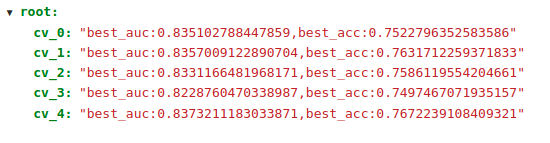

In [17]:
trainer.prefix_save_path = "../loss_test/LOG_[06.10_02:47]/"

In [21]:
preds = [0 for _ in pred]

In [29]:
preds = np.zeros_like(preds).astype(np.float64)

In [30]:
for i in range(5):
    prefix = f"cv_{i}"
    
    preds += np.array(trainer._inference(test_dataset, prefix=prefix))

In [33]:
preds = preds / 5

In [34]:
with open(p.join(trainer.prefix_save_path, "test.csv"), "w", encoding="utf8") as w:
    w.write("id,prediction\n")
    for idx, proba in enumerate(preds):
        w.write(f"{idx},{proba}\n")